# Analyse Exploratoire

Ce notebook renferme toute l'analyse exploratoire concernant le projet "Segmentez des clients d'un site e-commerce".

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px
import time
import warnings
warnings.filterwarnings('ignore')

### Méthodes du projet

In [2]:
def translate_product_category(data_products):
    mapping_names = pd.read_csv("product_category_name_translation.csv", encoding='utf-8', sep=',', index_col="product_category_name").to_dict()
    if 'product_category_name' in data_products.columns:
        data_products.replace({"product_category_name": mapping_names['product_category_name_english']}, inplace=True)

In [3]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

In [134]:
def show_unique_values(df, col, display_pie=True):
    temp_val_count = df[col].value_counts(normalize=True)
    df_val_count = temp_val_count.rename_axis("categ").to_frame("%")
    df_val_count["%"] = round(df_val_count["%"]*100, 2)
    df_val_count["%_cumul"] = df_val_count["%"].cumsum()
    # afficher la majeur partie des catégories
    sub_display = df_val_count.loc[df_val_count["%_cumul"] <= 85, :]
    if len(sub_display) < 5:
        display(df_val_count.head())
    else:
        display(sub_display.head(len(sub_display)))
    if display_pie:
        temp_val_count.plot(kind='pie', autopct=show_perc, labels=show_labels(temp_val_count), label='')
        plt.axis('equal')
        plt.show()

In [5]:
def show_missing_value_list(df, top=10, precision=3):
    miss_values = round(df.isnull().mean()*100, precision).sort_values(ascending=False)
    missing_val_df = pd.DataFrame(miss_values, columns = ["%"])
    display(missing_val_df.head(top))

In [6]:
# pour séparer les colonnes par type de donnée
def split_data_num_categ(df, silent=False):
    result = []
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    dict_col = {
        'numeric': [],
        'category': [],
        'boolean': [],
        'datetime': [],
        'deltatime': []
    }
    
    for col in df.columns:
        if df[col].dtype.name in ('float64', 'int64'):
            dict_col['numeric'].append(col)
        elif df[col].dtype.name in ('object', 'category'):
            dict_col['category'].append(col)
        elif df[col].dtype.name == 'bool':
            dict_col['boolean'].append(col)
        elif df[col].dtype.name == 'datetime64[ns]':
            dict_col['datetime'].append(col)
        elif df[col].dtype.name == 'timedelta[ns]':
            dict_col['deltatime'].append(col)
        else:
            print("Type de données non connu :", df[col].dtype.name, "pour la colonne", col)

    if not silent:
        print("Voici la répartition des colonnes par type de données :")
    for key, value in dict_col.items():
        nb_col_by_type = len(value)
        if not silent:
            print(key, ":", nb_col_by_type, "colonnes.")
        if nb_col_by_type > 0:
            result.append(df[value])
    
    return result

In [7]:
def show_corr_col(df, data_num, threshold=0.9, top=10):
    list_col_num = data_num.columns
    corr = df[list_col_num].corr().values
    nb_col = len(data_num.columns)
    res = []
    for i in range(nb_col):
        for j in range(i+1, nb_col):
            if abs(corr[i,j]) >= threshold:
                # print(list_col_num[i], ' ', list_col_num[j], ' ', round(corr[i,j], 3))
                res.append([list_col_num[i], list_col_num[j], round(corr[i,j], 3)])
    result = pd.DataFrame(res, columns=['col1', 'col2', 'corr'])
    result = result.sort_values(by="corr", ascending=False)
    display(result.head(top))

In [8]:
def plot_univarie(df, list_col):
    for col in list_col:
        print("-"*70)
        print("Colonne :", col)
        # mesures de tendances centrales
        print("moyenne : ", df[col].mean())
        print("médiane : ", df[col].median())
        print("mode : ", df[col].mode())
        print("min : ", df[col].min())
        print("max : ", df[col].max())
        quartiles = [np.percentile(df[col], p) for p in [25, 75]]
        print("quartiles : ", quartiles)
        # mesures de dispersion
        print("variance : ", df[col].var(ddof=0))
        print("écart-type : ", df[col].std(ddof=0))
        print("coefficient de variation : ", df[col].std(ddof=0)/df[col].mean())
        # mesures de forme
        print("skewness : ", df[col].skew())
        print("kurtosis : ", df[col].kurtosis())
        df[col].hist(bins=25)
        plt.xlabel(col)
        # pour tracer les 1er et 3ème quartiles
        min_ylim, max_ylim = plt.ylim()
        # plt.xticks(np.arange(-15, 41, 5))
        plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
        plt.text(quartiles[0], max_ylim*0.95, ' {:.0f}'.format(quartiles[0]))
        plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
        plt.text(quartiles[1], max_ylim*0.85, ' {:.0f}'.format(quartiles[1]))
        plt.show()
        print("-"*70)

In [9]:
def boxplot_univarie(df, list_col, showfliers=True):
    for col in list_col:
        print("-"*70)
        print("Colonne :", col)
        display(df.head())
        df.boxplot(column=col, vert=False, showfliers=showfliers)
        plt.show()
        print("-"*70)

In [10]:
def show_pair_plot(df):
    temp_data_num, *remain = split_data_num_categ(df, silent=True)
    sns.pairplot(df[temp_data_num.columns])

In [11]:
def remove_dupli_row(df, col_to_compare):
    nb_line_orig = df.shape[0]
    df = df[col_to_compare].drop_duplicates().reset_index(drop=True)
    diff = nb_line_orig - df.shape[0]
    if diff > 0:
        print("En supprimant les", diff, "lignes dupliquées, le dataset passe de", nb_line_orig, "lignes à", df.shape[0], "lignes.")
    else:
        print("Aucunes lignes dupliquées pour la liste de colonnes :", col_to_compare)

In [12]:
def display_pie_plot(df, list_col):
    for col in list_col:
        print("Colonne :", col)
        temp_val_count = df[col].value_counts(normalize=True)
        temp_val_count.plot(kind="pie", autopct=show_perc, labels=show_labels(temp_val_count), label='')
        plt.show()

In [104]:
def show_corr_anova_col(df, list_col_categ, list_col_num, threshold=0.6):
    # X : variable qualitative, ie catégorielle
    # Y : variable quantitative, ie numérique
    def eta_squared(x,y):
        moyenne_y = y.mean()
        classes = []
        for classe in x.unique():
            yi_classe = y[x==classe]
            classes.append({'ni': len(yi_classe),
                            'moyenne_classe': yi_classe.mean()})
        SCT = sum([(yj-moyenne_y)**2 for yj in y])
        SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
        return SCE/SCT
    
    start = time.time()
    print("On dénombre", len(list_col_categ) * len(list_col_num), "combinaisons à calculer.")
    for X in list_col_categ:
        # print("Colonne catégorielle :", X)
        for Y in list_col_num:
            # print("Colonne numérique :", Y)
            temp_eta = eta_squared(df[X],df[Y])
            if temp_eta >= threshold:
                print("-"*70)
                print("Colonne catégorielle :", X)
                print("Colonne numérique :", Y)
                print("Correlation de", round(temp_eta, 3))
    
    end = time.time()
    delta = round(end - start, 0)
    print("Corrélations ANOVA calculées en :", delta, "s, soit", round(delta/60, 0), "min, soit" , round(delta/3600, 0), "h.")

In [14]:
def Plot_world(text):
    comment_words = ' '
    for val in text: 

        # typecaste each val to string 
        val = str(val) 
        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '

    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='white', 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

# I) Elaboration du dataset d'étude

Les données sont dispersées en 8 fichiers. Nous allons d'abord charger chaque fichier pour effectuer un traitement de filtrage préalable si besoin.

## Chargement et traitement des différents fichiers

Il est plus pertinent de faire les traitements de nettoyage et filtrage avant de fusionner les tables. En effet, la fusion va provoquer la création de lignes supplémentaires. Cela va complètement déséquilibrer le master dataset et donc biaiser le traitement des valeurs manquantes.

### Customers

In [15]:
data_customers = pd.read_csv(
    "input/olist_customers_dataset.csv", encoding='utf-8', sep=',',
    dtype=object) # le zip code peut commencer par 0

In [16]:
data_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Regardons les variables de ce dataset : 
 - `customer_id` : identifiant servant de foreign key pour la table **orders**
 - `customer_unique_id` : identifiant unique du client. Un même identifiant unique peut avoir plusieurs `customer_id`
 - `customer_zip_code_prefix` : identifiant servant de foreign key pour la table **geolocation**
 - `customer_city` : ville où vit le client
 - `customer_state` : état où vit le client

In [17]:
print("Ce dataset présente", data_customers.shape[0], "lignes pour", data_customers.shape[1], "colonnes.")

Ce dataset présente 99441 lignes pour 5 colonnes.


### Products

In [18]:
data_products = pd.read_csv(
    "input/olist_products_dataset.csv", encoding='utf-8', sep=',')

In [19]:
data_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


Regardons les variables de ce dataset : 
 - `product_id` : identifiant servant de aussi de foreign key pour la table **order_items**
 - `product_category_name` : catégorie du produit
 - `product_name_lenght` : longueur du nom sur la fiche produit
 - `product_description_lenght` : longueur de la description sur la fiche produit
 - `product_photos_qty` : nombre de photo sur la fiche produit
 - `product_weight_g` : poids du produit
 - `product_length_cm` : longueur du produit
 - `product_height_cm` : hauteur du produit
 - `product_width_cm` : largeur du produit

La variable `product_category_name` peut être traduite par l'intérmédiaire du fichier fournit en annexe.

In [20]:
translate_product_category(data_products)

Regardons les corrélations possibles entre les différentes variables numériques.

In [21]:
# show_pair_plot(data_products)

On n'observe rien de marquant. Regardons maintenant les valeurs manquantes.

In [22]:
show_missing_value_list(data_products)

,%
product_category_name,1.851
product_name_lenght,1.851
product_description_lenght,1.851
product_photos_qty,1.851
product_weight_g,0.006
product_length_cm,0.006
product_height_cm,0.006
product_width_cm,0.006
product_id,0.000


On remarque que certaines variables ont la même valeur de données manquantes : 
 - la désignation de la fiche produit
 - les dimensions

Même si certaines données sont manquantes, ils peuvent avoir été achetés. ils ont donc potentiellement un prix et une fréquence d'achat. Nous allons donc les garder mais les traiter de la manière suivante : 
 - `product_category_name` : on renseigne la valeur "not_defined" car aucun moyen de savoir ce qu'est le produit
 - `product_name_lenght`, `product_description_lenght` et `product_photos_qty` : on renseigne la valeur minimale car nous faisons l'approximation qu'on ne peut créer une fiche sans aucune de ces données
 - `product_weight_g`, `product_length_cm`, `product_height_cm` et `product_width_cm` : on renseigne la valeur médiane

In [23]:
# traitement avec Other
data_products["product_category_name"].fillna("not_defined", inplace=True)
# traitement par le minimum
for col_fiche in ["product_name_lenght", "product_description_lenght", "product_photos_qty"]:
    data_products[col_fiche].fillna(data_products[col_fiche].min(), inplace=True)
# traitement par la médiane
for col_dim in ["product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]:
    data_products[col_dim].fillna(data_products[col_dim].median(), inplace=True)

Regardons maintenant les outliers.

In [24]:
data_products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000
mean,47.672089,757.287154,2.166975,2276.376802,30.814725,16.937422,23.196534
std,11.720832,637.657356,1.728063,4281.926387,16.914005,13.637175,12.078707
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,41.000000,326.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,584.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,961.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


La seule valeur aberrante observée est le poids minimum à 0g.

In [25]:
poids_a_zero = data_products.loc[data_products["product_weight_g"]==0]
print("Poids à zéro :", len(poids_a_zero), ", soit", str(round(len(poids_a_zero)/len(data_products)*100, 2)), "% du total.")

Poids à zéro : 4 , soit 0.01 % du total.


In [26]:
poids_a_zero.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
9769,81781c0fed9fe1ad6e8c81fca1e1cb08,bed_bath_table,51.0,529.0,1.0,0.0,30.0,25.0,30.0
13683,8038040ee2a71048d4bdbbdc985b69ab,bed_bath_table,48.0,528.0,1.0,0.0,30.0,25.0,30.0
14997,36ba42dd187055e1fbe943b2d11430ca,bed_bath_table,53.0,528.0,1.0,0.0,30.0,25.0,30.0
32079,e673e90efa65a5409ff4196c038bb5af,bed_bath_table,53.0,528.0,1.0,0.0,30.0,25.0,30.0


On voit que ces produits sont de la même catégorie et ont les mêmes dimensions. On va donc récupérer la valeur médiane des produits ayant ces critères.

In [27]:
filtered_poids_zero = data_products.loc[
    (data_products["product_category_name"]=="bed_bath_table") &
    (data_products["product_length_cm"]==30) &
    (data_products["product_height_cm"]==25) &
    (data_products["product_width_cm"]==30) &
    (data_products["product_weight_g"]!=0), :]
data_products.loc[data_products["product_weight_g"]==0,"product_weight_g"] = filtered_poids_zero["product_weight_g"].median()

In [28]:
# data_products["product_volume_l"] = data_products["product_length_cm"] * data_products["product_height_cm"] * data_products["product_width_cm"] / 1000

In [29]:
print("Ce dataset présente", data_products.shape[0], "lignes pour", data_products.shape[1], "colonnes.")

Ce dataset présente 32951 lignes pour 9 colonnes.


### Sellers

In [30]:
data_sellers = pd.read_csv(
    "input/olist_sellers_dataset.csv", encoding='utf-8', sep=',',
    dtype=object) # le zip code peut commencer par 0

In [31]:
data_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,04195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


Regardons les variables de ce dataset : 
 - `seller_id` : identifiant servant de aussi de foreign key pour la table **order_items**
 - `seller_zip_code_prefix` : identifiant servant de foreign key pour la table **geolocation**
 - `seller_city` : ville où est basé le vendeur
 - `seller_state` : état dans lequel est basé le vendeur

In [32]:
print("Ce dataset présente", data_sellers.shape[0], "lignes pour", data_sellers.shape[1], "colonnes.")

Ce dataset présente 3095 lignes pour 4 colonnes.


### Geolocation

In [33]:
data_geolocation = pd.read_csv(
    "input/olist_geolocation_dataset.csv", encoding='utf-8', sep=',',
    dtype={'geolocation_zip_code_prefix': 'object'}) # le zip code peut commencer par 0

In [34]:
data_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,01037,-23.545621,-46.639292,sao paulo,SP
1,01046,-23.546081,-46.644820,sao paulo,SP
2,01046,-23.546129,-46.642951,sao paulo,SP
3,01041,-23.544392,-46.639499,sao paulo,SP
4,01035,-23.541578,-46.641607,sao paulo,SP


Regardons les variables de ce dataset : 
 - `geolocation_zip_code_prefix` : identifiant servant de foreign key pour les tables **customers** et **sellers**
 - `geolocation_lat` : latitude
 - `geolocation_lng` : longitude
 - `geolocation_city` : ville
 - `geolocation_state` : état (du pays)

In [35]:
remove_dupli_row(data_geolocation, data_geolocation.columns)

En supprimant les 261831 lignes dupliquées, le dataset passe de 1000163 lignes à 738332 lignes.


In [36]:
print("Ce dataset présente", data_geolocation.shape[0], "lignes pour", data_geolocation.shape[1], "colonnes.")

Ce dataset présente 1000163 lignes pour 5 colonnes.


### Payments

In [37]:
data_payments = pd.read_csv(
    "input/olist_order_payments_dataset.csv", encoding='utf-8', sep=',')

In [38]:
data_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


Regardons les variables de ce dataset : 
 - `order_id` : identifiant servant de aussi de foreign key pour la table **orders**
 - `payment_sequential` : séquence d'un paiement si en plusieurs fois
 - `payment_type` : méthode de paiement
 - `payment_installments` : nombre d'échance pour le paiement de la commande
 - `payment_value` : montant de la transaction

NB : Je voulais faire une aggrégation des données pour avoir le montant total et le nombre d'échéance payées. Mais le fait que la commande peut avoir plusieurs méthodes de paiement m'en empêche.

In [39]:
data_payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


On voit des valeurs aberrantes pour le montant de la transaction et le nombre d'échéance avec des valeurs à zéro.

In [40]:
mont_trans_a_zero = data_payments.loc[data_payments["payment_value"]==0, :]
print("Montant de la transaction à zéro :", len(mont_trans_a_zero), ", soit", str(round(len(mont_trans_a_zero)/len(data_payments)*100, 2)), "% du total.")
mont_trans_a_zero.head(len(mont_trans_a_zero))

Montant de la transaction à zéro : 9 , soit 0.01 % du total.


,order_id,payment_sequential,payment_type,payment_installments,payment_value
19922,8bcbe01d44d147f901cd3192671144db,4,voucher,1,0.0
36822,fa65dad1b0e818e3ccc5cb0e39231352,14,voucher,1,0.0
43744,6ccb433e00daae1283ccc956189c82ae,4,voucher,1,0.0
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.0
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.0
62674,45ed6e85398a87c253db47c2d9f48216,3,voucher,1,0.0
77885,fa65dad1b0e818e3ccc5cb0e39231352,13,voucher,1,0.0
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.0
100766,b23878b3e8eb4d25a158f57d96331b18,4,voucher,1,0.0


Le type de paiement de ces montants sont voucher (bon alimentaire) et non défini. Regardons les séparément.

In [41]:
pay_voucher = data_payments.loc[data_payments["payment_type"]=="voucher", :]
pay_voucher.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
25,5cfd514482e22bc992e7693f0e3e8df7,2,voucher,1,45.17
68,947e9c6bfd83a06953c420ef92d3da6e,1,voucher,1,69.46
70,e3e9e3295f4e1512167c232a0aaae8a5,1,voucher,1,50.80
75,3689194c14ad4e2e7361ebd1df0e77b0,2,voucher,1,57.53
102,21b8b46679ea6482cbf911d960490048,2,voucher,1,43.12


Les bons alimentaires ont des montants. nous allons renseigner la valeur médiane pour celle à 0.

In [42]:
filtered_voucher_zero = data_payments.loc[
    (data_payments["payment_type"]=="voucher") &
    (data_payments["payment_value"]!=0), :]
data_payments.loc[
    (data_payments["payment_type"]=="voucher") &
    (data_payments["payment_value"]==0),
    "payment_value"] = filtered_voucher_zero["payment_value"].median()

In [43]:
pay_not_defined = data_payments.loc[data_payments["payment_type"]=="not_defined", :]
pay_not_defined.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.0
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.0
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.0


Les 3 seules lignes de paiement ayant le type non défini ont des montants à zéro. Nous allons supprimer ces lignes.

In [44]:
data_payments = data_payments.loc[data_payments["payment_type"] != "not_defined", :].reset_index(drop=True)

In [45]:
pay_install_a_zero = data_payments.loc[data_payments["payment_installments"]==0, :]
pay_install_a_zero.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
46982,744bade1fcf9ff3f31d860ace076d422,2,credit_card,0,58.69
79012,1a57108394169c0b47d8f876acc9ba2d,2,credit_card,0,129.94


Regardons les autres lignes de cette commande.

In [46]:
temp_sub_pay = data_payments.loc[
    (data_payments["order_id"]=='744bade1fcf9ff3f31d860ace076d422') | 
    (data_payments["order_id"]=='1a57108394169c0b47d8f876acc9ba2d'), :]
temp_sub_pay.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
46982,744bade1fcf9ff3f31d860ace076d422,2,credit_card,0,58.69
79012,1a57108394169c0b47d8f876acc9ba2d,2,credit_card,0,129.94


Etant donné la nature de la colonne, la valeur est de minimum 2 puisqu'il y a cette valeur dans le nombre de séquence. Nous choisissons de renseigner 2.

In [47]:
data_payments.loc[
    (data_payments["order_id"]=='744bade1fcf9ff3f31d860ace076d422') | 
    (data_payments["order_id"]=='1a57108394169c0b47d8f876acc9ba2d'),
    "payment_installments"] = 2

Nous allons observer où en sont les paiements dans leurs échéances.

In [48]:
agg_pay = {
    'payment_sequential': ['min', 'max', 'count'],
    'payment_installments': ['min', 'max', 'count'],
}

In [49]:
compare_seq = data_payments.groupby(['order_id']).agg(agg_pay)
compare_seq.head()

payment_sequential            \
                                                min max count   
order_id                                                        
00010242fe8c5a6d1ba2dd792cb16214                  1   1     1   
00018f77f2f0320c557190d7a144bdd3                  1   1     1   
000229ec398224ef6ca0657da4fc703e                  1   1     1   
00024acbcdf0a6daa1e931b038114c75                  1   1     1   
00042b26cf59d7ce69dfabb4e55b4fd9                  1   1     1   

                                 payment_installments            
                                                  min max count  
order_id                                                         
00010242fe8c5a6d1ba2dd792cb16214                    2   2     1  
00018f77f2f0320c557190d7a144bdd3                    3   3     1  
000229ec398224ef6ca0657da4fc703e                    5   5     1  
00024acbcdf0a6daa1e931b038114c75                    2   2     1  
00042b26cf59d7ce69dfabb4e55b4fd9                    3   3     1

On voit tout de suite que l'on a des commandes qui en sont à leur premier versement alors qu'il est prévu plus. Ce qui implique que nous n'avons pas toutes les données disponible pour cette table. Il est possible qu'elle ne nous soit pas très utile pour notre étude. Nous allons néanmoins quantifier à quel point cette table manque de données.

In [50]:
def evaluate_miss_pay_data(df):
    compare_seq["delta_seq"] = compare_seq[('payment_sequential', 'max')] - compare_seq[('payment_sequential', 'min')] + 1
    compare_seq["delta_install"] = compare_seq[('payment_installments', 'max')] - compare_seq[('payment_installments', 'min')] + 1
    compare_seq["delta_counts"] = compare_seq[('payment_installments', 'count')] - compare_seq[('payment_sequential', 'count')]
    
    compare_seq["miss_count"] = 0
    compare_seq.loc[compare_seq[("delta_seq", "")] != compare_seq[('payment_sequential', 'count')], "miss_count"] += 1
    compare_seq.loc[compare_seq[("delta_install", "")] != compare_seq[('payment_installments', 'count')], "miss_count"] += 1
    compare_seq.loc[compare_seq[("delta_counts", "")] != 0, "miss_count"] += 1
    
evaluate_miss_pay_data(compare_seq)

In [51]:
nb_orders = data_payments["order_id"].nunique()
nb_miss_pay = len(compare_seq.loc[compare_seq["miss_count"] > 0, :])
print("Il manque des données pour", nb_miss_pay, "commandes, soit", str(round(nb_miss_pay/nb_orders*100, 2)), "% des commandes.")

Il manque des données pour 2691 commandes, soit 2.71 % des commandes.


In [52]:
print("Ce dataset présente", data_payments.shape[0], "lignes pour", data_payments.shape[1], "colonnes.")

Ce dataset présente 103883 lignes pour 5 colonnes.


### Reviews

In [53]:
review_date_col = [
    "review_creation_date",
    "review_answer_timestamp"]
data_reviews = pd.read_csv(
    "input/olist_order_reviews_dataset.csv", encoding='utf-8', sep=',',
    parse_dates=review_date_col)

In [54]:
data_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


Regardons les variables de ce dataset : 
 - `review_id` : identifiant unique de la review
 - `order_id` : identifiant servant de aussi de foreign key pour la table **orders**
 - `review_score` : note de la review allant de 1 à 5
 - `review_comment_title` : titre du commentaire de la review
 - `review_comment_message` : corps du commentaire de la review
 - `review_creation_date` : date à laquelle la review a été publiée
 - `review_answer_timestamp` : date à laquelle la review a eu une réponse

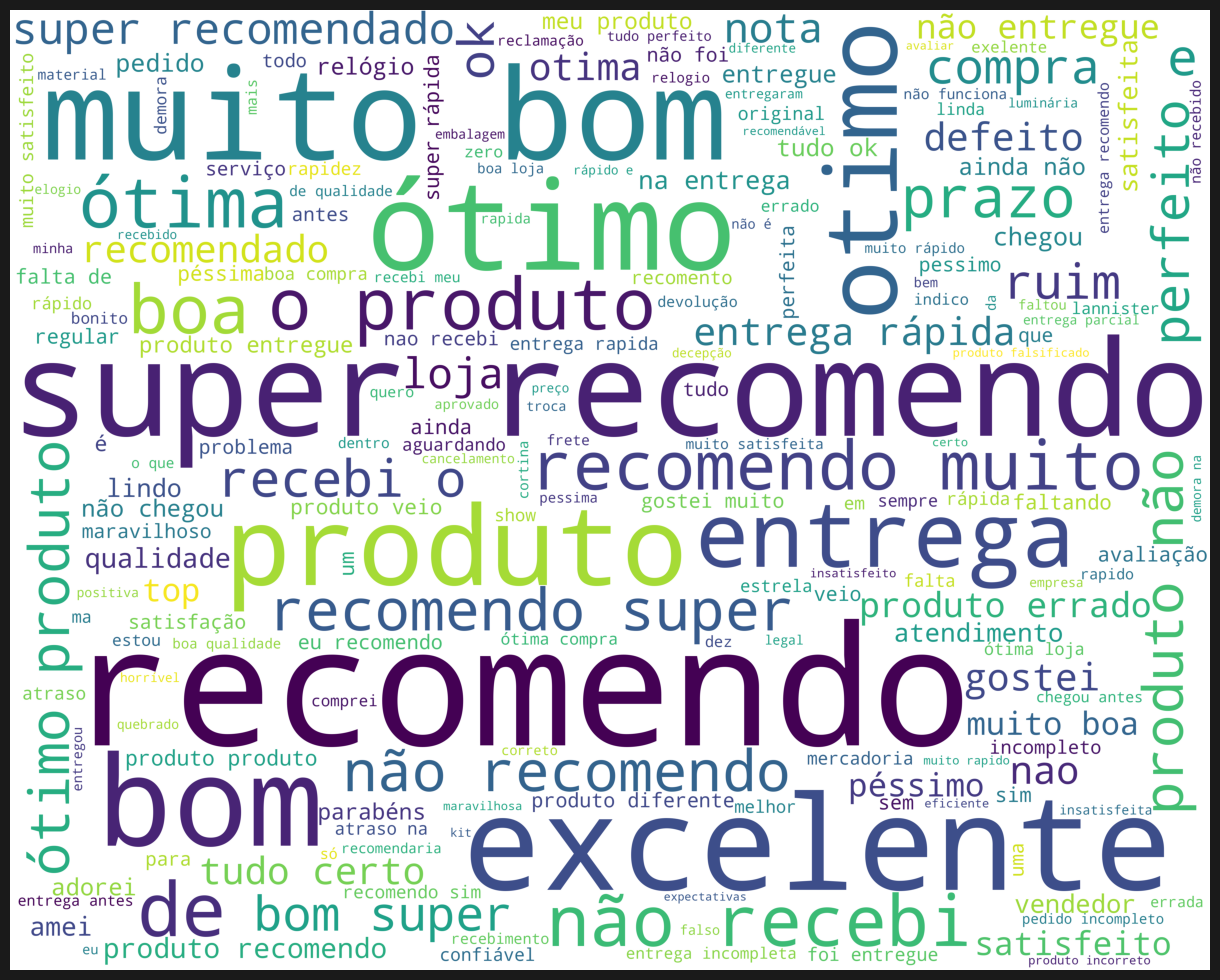

In [55]:
from wordcloud import WordCloud
sub_data = data_reviews.loc[data_reviews["review_comment_title"].notnull(), :]
text = sub_data["review_comment_title"].values
Plot_world(text)

On remarque que certains mots sont plus récurrents dans les titres des commentaires des reviews : 
 - otimo : excellent
 - muito bom : très bon
 - excelente : génial
 - super recomendo : je recommande vivement

In [56]:
show_missing_value_list(data_reviews, top=5, precision=1)

,%
review_comment_title,88.3
review_comment_message,58.7
review_id,0.0
order_id,0.0
review_score,0.0


On peut voir que les notes sont certes toutes renseignée, mais les commentaires ne sont pas forcément remplis. Etant donné le peu de données dans les colonnes `review_comment_title` et `review_comment_message`, nous choisissons de les supprimer.

In [57]:
data_reviews.drop(['review_comment_title', 'review_comment_message'], axis=1, inplace=True)

In [58]:
print("Ce dataset présente", data_reviews.shape[0], "lignes pour", data_reviews.shape[1], "colonnes.")

Ce dataset présente 99224 lignes pour 5 colonnes.


### Items

In [59]:
data_items = pd.read_csv(
    "input/olist_order_items_dataset.csv", encoding='utf-8', sep=',',
    parse_dates=["shipping_limit_date"])

In [60]:
data_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Regardons les variables de ce dataset : 
 - `order_id` : identifiant unique de la commande
 - `order_item_id` : quantité d'achat du produit
 - `product_id` : identifiant servant de aussi de foreign key pour la table **products**
 - `seller_id` : identifiant servant de aussi de foreign key pour la table **sellers**
 - `shipping_limit_date` : date limite pour le vendeur pour confier le produit au service logistique
 - `price` : prix du produit au moment de la commande
 - `freight_value` : frais de port associés au produit (et non à la commande entière) au moment de la commande

Dans order_items, les produits sont présents plusieurs fois. Pour chaque produits, on a une ligne par quantité d'achat. Chaque ligne nous montre son prix et ses frais de port au moment de l'achat. La variable `order_item_id` renseigne sur la quantité achetée. S'il y a 3 items dans le même panier, il y aura 3 lignes avec les valeurs 1, 2 et 3. Il y aura cependant la même valeurs pour le prix et les frais de port.    
On va d'abord ordonner les lignes par ordre décroissant de la variable `order_item_id`. Puis on va garder la première des lignes dupliquées selon les critères des autres colonnes.

In [61]:
nb_lines_orig_oi = data_items.shape[0]
data_items = data_items.sort_values('order_item_id', ascending=False).drop_duplicates(["order_id", "product_id", "seller_id", "price", "freight_value"])
diff = nb_lines_orig_oi - data_items.shape[0]
print("En supprimant les", diff, "lignes dupliquées, le dataset passe de", nb_lines_orig_oi, "lignes à", data_items.shape[0], "lignes.")

En supprimant les 10225 lignes dupliquées, le dataset passe de 112650 lignes à 102425 lignes.


In [62]:
data_items.describe()

,order_item_id,price,freight_value
count,102425.000000,102425.000000,102425.000000
mean,1.150539,124.422006,20.111152
std,0.563005,188.926084,15.884700
min,1.000000,0.850000,0.000000
25%,1.000000,40.000000,13.140000
50%,1.000000,78.800000,16.320000
75%,1.000000,139.000000,21.220000
max,21.000000,6735.000000,409.680000


Nous voyons de possibles outliers au niveau du prix et des frais de port. On a des valeurs maximales à, respectivement, 6735 et 409,68. Cependant, nous ne savons pas quel genre de produit nous avons. Il est possible que ce soit les vrai prix, surtout s'ils sont exprimés en real brésilien. Pour les frais de port, en fonction du colis, on peut très bien arriver à ce genre de valeur.

In [63]:
print("Ce dataset présente", data_items.shape[0], "lignes pour", data_items.shape[1], "colonnes.")

Ce dataset présente 102425 lignes pour 7 colonnes.


### Orders

In [64]:
order_date_col = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date']
data_orders = pd.read_csv(
    "input/olist_orders_dataset.csv", encoding='utf-8', sep=',',
    parse_dates=order_date_col)

In [65]:
data_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


Regardons les variables de ce dataset : 
 - `order_id` : identifiant servant de aussi de foreign key pour la table **orders**
 - `customer_id` : identifiant servant de aussi de foreign key pour la table **customers**
 - `order_status` : étape dans laquelle est la commande
 - `order_purchase_timestamp` : date à laquelle la commande a été faite par le client
 - `order_approved_at` : date à laquelle le paiement a été approuvé
 - `order_delivered_carrier_date` : date à laquelle le colis a été confié au service de logistique
 - `order_delivered_customer_date` : date à laquelle le colis a été livré au client
 - `order_estimated_delivery_date` : date estimée de livraison au moment de la commande

In [66]:
remove_dupli_row(data_orders, data_orders.columns)

Aucunes lignes dupliquées pour la liste de colonnes : Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')


In [67]:
show_missing_value_list(data_orders)

,%
order_delivered_customer_date,2.982
order_delivered_carrier_date,1.793
order_approved_at,0.161
order_id,0.000
customer_id,0.000
order_status,0.000
order_purchase_timestamp,0.000
order_estimated_delivery_date,0.000


Regardons de plus près les 3 dates ayant des valeurs manquantes. Elles peuvent être justifiées.

In [68]:
sub_data_delivered_date = data_orders.loc[data_orders["order_delivered_customer_date"].isnull(), :]
show_unique_values(sub_data_delivered_date, 'order_status', display_pie=False)

shipped        0.373356
canceled       0.208769
unavailable    0.205396
invoiced       0.105902
processing     0.101518
Name: order_status, dtype: float64

La date de livraisons n'est pas renseignée pour des colis non livrés. Donc c'est normal.

In [69]:
sub_data_carrier_date = data_orders.loc[data_orders["order_delivered_carrier_date"].isnull(), :]
show_unique_values(sub_data_carrier_date, 'order_status', display_pie=False)

unavailable    0.341559
canceled       0.308469
invoiced       0.176108
processing     0.168817
created        0.002804
Name: order_status, dtype: float64

La date indiquant que le colis a été confié à la logistique n'est pas renseignée pour des colis non envoyés. Donc c'est normal.

In [70]:
sub_data_approuved_date = data_orders.loc[data_orders["order_approved_at"].isnull(), :]
show_unique_values(sub_data_approuved_date, 'order_status', display_pie=False)

canceled     0.88125
delivered    0.08750
created      0.03125
Name: order_status, dtype: float64

La date d'approbation de la commande n'est pas renseigné pour des colis livrés. Ce n'est pas normal. Regardons ça de plus près.

In [71]:
sub_deliv_appr_date = data_orders.loc[
    (data_orders["order_approved_at"].isnull()) &
    (data_orders["order_status"] == "delivered"), :]
sub_deliv_appr_date.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20


Pour plus de cohérence, nous allons renseigner la date de commande + 1 seconde.

In [72]:
data_orders.loc[
    (data_orders["order_approved_at"].isnull()) &
    (data_orders["order_status"] == "delivered"),
    "order_approved_at"] = data_orders.loc[
    (data_orders["order_approved_at"].isnull()) &
    (data_orders["order_status"] == "delivered"),
    "order_purchase_timestamp"] + pd.to_timedelta(1, unit='s')

In [73]:
print("Ce dataset présente", data_orders.shape[0], "lignes pour", data_orders.shape[1], "colonnes.")

Ce dataset présente 99441 lignes pour 8 colonnes.


## Elaboration dataset brut

In [74]:
data = pd.merge(data_customers, data_orders, on="customer_id", how="inner")
data = pd.merge(data, data_payments, on="order_id", how="inner")
data = pd.merge(data, data_reviews, on="order_id", how="inner")
data = pd.merge(data, data_items, on="order_id", how="inner")
data = pd.merge(data, data_products, on="product_id", how="inner")
data = pd.merge(data, data_sellers, on="seller_id", how="inner")
print("There are", data.shape[0], "lines characterised by", data.shape[1], "columns.")

There are 106837 lines characterised by 37 columns.


In [75]:
data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP
2,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP
3,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP
4,fd3a0b1bd209f0e7d420c9c3d1127613,567ab47ca4deb92d46dbf54dce07d0a7,88460,angelina,SC,574fe1739f65af76badd0999db300b4f,delivered,2017-03-23 15:10:17,2017-03-23 15:25:11,2017-03-28 18:23:51,...,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,08577,itaquaquecetuba,SP


In [76]:
data_num, data_categ, data_date = split_data_num_categ(data)

Voici la répartition des colonnes par type de données :
numeric : 14 colonnes.
category : 15 colonnes.
boolean : 0 colonnes.
datetime : 8 colonnes.
deltatime : 0 colonnes.


In [77]:
data.to_csv("master_dataset.csv", sep='\t', encoding='utf-8')

## Dataset d'étude

Le dataset brut ne nous sera pas entièrement utile. Certaines tables et certaines colonnes uniquement seront utilisés dans notre étude. Nous rappelons que la problématique métier est de segmenter les clients en terme de commandes et de satisfaction. Pour cela, nousa vons besoin des tables : 
 - Clients
 - Commandes
 - Reviews
 - Items par commande
 - Produits

Les 3 autres autres tables sont certes intéressantes, mais pour d'autres études.

In [78]:
data_study = pd.merge(data_customers, data_orders, on="customer_id", how="inner")
data_study = pd.merge(data_study, data_reviews, on="order_id", how="inner")
data_study = pd.merge(data_study, data_items, on="order_id", how="inner")
data_study = pd.merge(data_study, data_products, on="product_id", how="inner")
print("There are", data_study.shape[0], "lines characterised by", data_study.shape[1], "columns.")

There are 102230 lines characterised by 30 columns.


In [79]:
data_study.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,124.99,21.88,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,112.99,24.90,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
2,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,124.99,15.62,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
3,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,106.99,30.59,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
4,fd3a0b1bd209f0e7d420c9c3d1127613,567ab47ca4deb92d46dbf54dce07d0a7,88460,angelina,SC,574fe1739f65af76badd0999db300b4f,delivered,2017-03-23 15:10:17,2017-03-23 15:25:11,2017-03-28 18:23:51,...,126.99,15.06,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0


In [80]:
data_study.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_id', 'review_score',
       'review_creation_date', 'review_answer_timestamp', 'order_item_id',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

La fusion étant faite, certaines colonnes de type foreign key ne sont plus utiles : `customer_zip_code_prefix`, `review_id`, `product_id` et `seller_id`.

In [81]:
data_study.drop(columns=['customer_zip_code_prefix', 'review_id', 'product_id', 'seller_id'], axis=1, inplace=True)
print("Le dataset d'étude présente", data_study.shape[0], "lignes caractérisées par", data_study.shape[1], "columns.")
print("Par rapport à notre dataset brut, nous avons gardé", round(data_study.shape[0]/data.shape[0]*100, 2), "% de lignes et", round(data_study.shape[1]/data.shape[1]*100, 2), "% de colonnes.")

Le dataset d'étude présente 102230 lignes caractérisées par 26 columns.
Par rapport à notre dataset brut, nous avons gardé 95.69 % de lignes et 70.27 % de colonnes.


In [82]:
data_num, data_categ, data_date = split_data_num_categ(data_study)

Voici la répartition des colonnes par type de données :
numeric : 11 colonnes.
category : 7 colonnes.
boolean : 0 colonnes.
datetime : 8 colonnes.
deltatime : 0 colonnes.


In [83]:
data_study.to_csv("study_dataset.csv", sep='\t', encoding='utf-8')

# II) Compréhension dataset d'études

Vérifions les données manquantes sur l'ensemble du jeu de données.

In [84]:
show_missing_value_list(data_study, top=5)

,%
order_delivered_customer_date,2.100
order_delivered_carrier_date,0.997
customer_id,0.000
order_item_id,0.000
product_height_cm,0.000


Nous avons bien uniquement les colonnes `order_delivered_customer_date` et `order_delivered_carrier_date`  ayant des valeurs manquantes justifiées.

## Analyse univariée

### Colonnes Catégorielles

In [85]:
data_categ.nunique().sort_values()

order_status                 7
customer_state              27
product_category_name       74
customer_city             4108
customer_unique_id       94721
customer_id              97917
order_id                 97917
dtype: int64

Certaines variables catégorielles sont intéressantes à regarder : `order_status`, `customer_state` et `product_category_name`. Regardons leur répartition respectives.

,%,%_cumul
categ,,
delivered,97.90,97.90
shipped,1.04,98.94
canceled,0.44,99.38
invoiced,0.31,99.69
processing,0.29,99.98


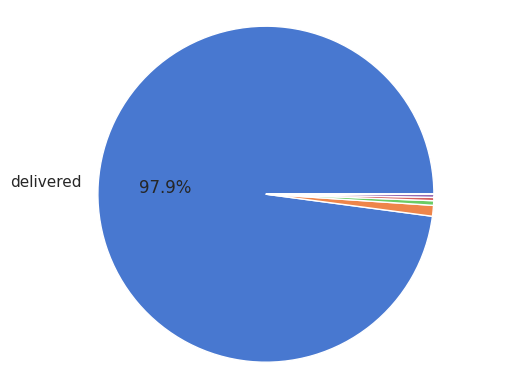

,%,%_cumul
categ,,
SP,42.07,42.07
RJ,12.87,54.94
MG,11.72,66.66
RS,5.54,72.20
PR,5.04,77.24
SC,3.64,80.88
BA,3.38,84.26


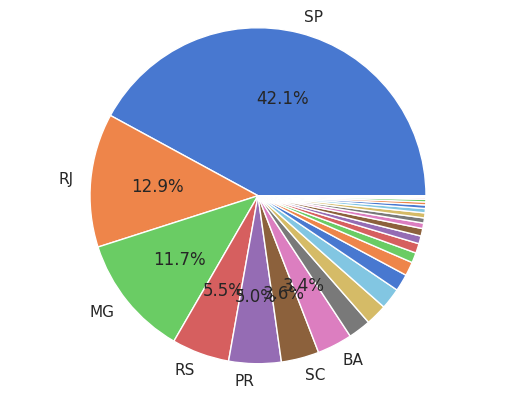

,%,%_cumul
categ,,
bed_bath_table,9.95,9.95
health_beauty,8.81,18.76
sports_leisure,7.69,26.45
computers_accessories,6.75,33.20
furniture_decor,6.64,39.84
housewares,5.87,45.71
watches_gifts,5.63,51.34
telephony,4.17,55.51
auto,3.90,59.41


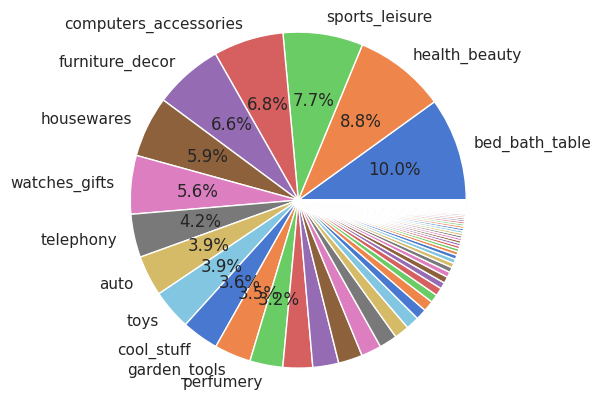

In [166]:
limit_perc = 3
categ_col_to_study = ['order_status', 'customer_state', 'product_category_name']
for col in categ_col_to_study:
    show_unique_values(data_study, col)

### Colonnes Numériques

In [87]:
show_corr_col(data_study, data_num, threshold=0.4, top=10)

,col1,col2,corr
1,freight_value,product_weight_g,0.611
3,product_weight_g,product_height_cm,0.581
5,product_length_cm,product_width_cm,0.552
4,product_weight_g,product_width_cm,0.511
2,product_weight_g,product_length_cm,0.465
0,price,freight_value,0.418


On remarque plusieurs corrélations : 
 - forte corrélation (>0.6) : entre le poids du produit et les frais de port. Ce qui semble logique.
 - corrélation modérée (>0.4) : entre les différentes dimensions et le poids. Ce qui semble logique également. Mais aussi entre les frais de port et le prix. C'est moins logique, mais c'est pour ça que la corrélation est modérée.

Les corrélations ne sont pas assez fortes pour écarter une variable ou une autre.

In [88]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_sequential,106837.0,1.094761,0.723067,1.00,1.00,1.00,1.00,29.00
payment_installments,106837.0,2.896029,2.724191,1.00,1.00,1.00,4.00,24.00
payment_value,106837.0,156.943631,217.198052,0.01,57.68,102.12,175.94,13664.08
review_score,106837.0,4.073589,1.355780,1.00,4.00,5.00,5.00,5.00
order_item_id,106837.0,1.149723,0.557548,1.00,1.00,1.00,1.00,21.00
price,106837.0,124.163629,188.103947,0.85,40.00,78.00,139.00,6735.00
freight_value,106837.0,20.144767,15.914993,0.00,13.14,16.34,21.23,409.68
product_name_lenght,106837.0,48.235583,11.230665,5.00,42.00,52.00,57.00,76.00
product_description_lenght,106837.0,773.963206,653.043843,4.00,340.00,594.00,977.00,3992.00
product_photos_qty,106837.0,2.217986,1.734293,1.00,1.00,1.00,3.00,20.00


Concernant les outliers, je ne vois rien de particulier à première vue. Regardons plutôt à l'aide des boxplot.

----------------------------------------------------------------------
Colonne : review_score
moyenne :  4.076367015553164
médiane :  5.0
mode :  0    5
Name: review_score, dtype: int64
min :  1
max :  5
quartiles :  [4.0, 5.0]
variance :  1.833364009679902
écart-type :  1.3540177287169848
coefficient de variation :  0.33216286059395567
skewness :  -1.344658578158898
kurtosis :  0.44462892747033544


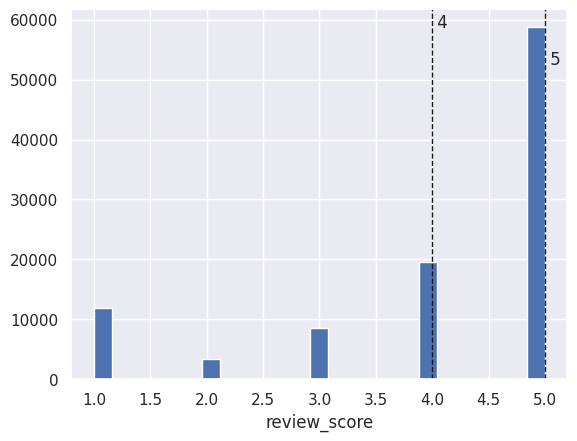

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : order_item_id
moyenne :  1.1502787831360657
médiane :  1.0
mode :  0    1
Name: order_item_id, dtype: int64
min :  1
max :  21
quartiles :  [1.0, 1.0]
variance :  0.31493951926714886
écart-type :  0.5611947249103014
coefficient de variation :  0.4878771417310564
skewness :  7.295881974174976
kurtosis :  103.61130370647132


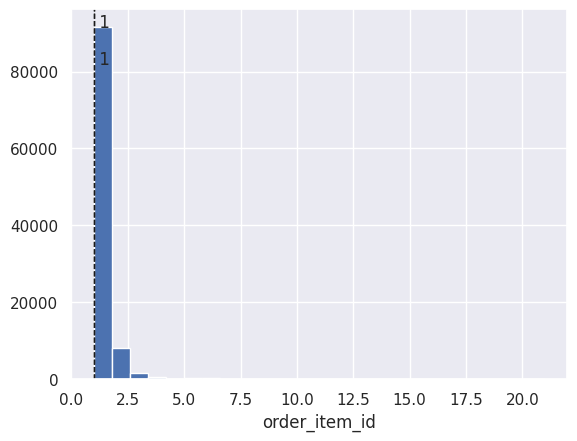

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : price
moyenne :  124.07637200430403
médiane :  78.0
mode :  0    59.9
Name: price, dtype: float64
min :  0.85
max :  6735.0
quartiles :  [40.0, 139.0]
variance :  35082.167691033086
écart-type :  187.30234299397614
coefficient de variation :  1.5095730151384414
skewness :  7.563038610525204
kurtosis :  105.9299639983164


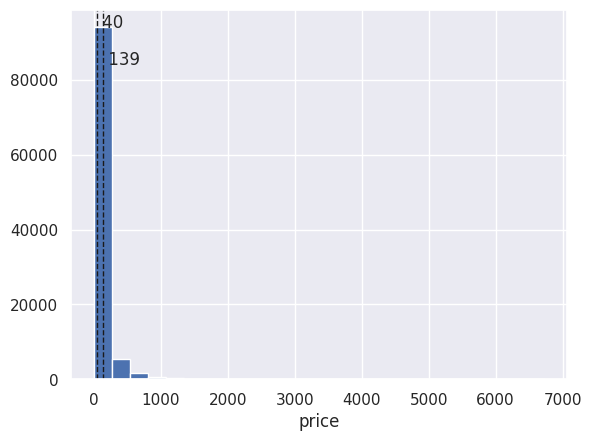

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : freight_value
moyenne :  20.097458084710944
médiane :  16.32
mode :  0    15.1
Name: freight_value, dtype: float64
min :  0.0
max :  409.68
quartiles :  [13.14, 21.19]
variance :  251.46633222985315
écart-type :  15.857690002956078
coefficient de variation :  0.7890395858081052
skewness :  5.548626296295182
kurtosis :  57.733596550942806


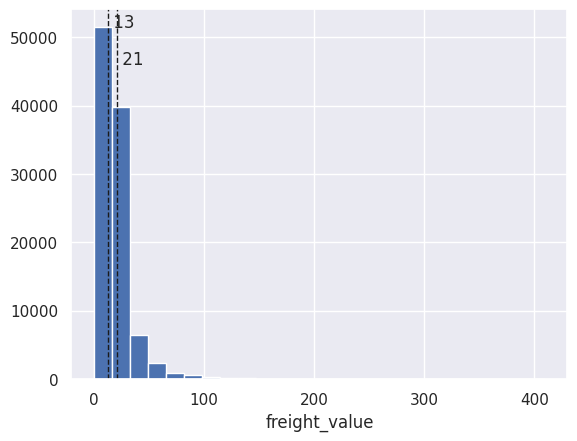

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_name_lenght
moyenne :  48.25299814144576
médiane :  52.0
mode :  0    59.0
Name: product_name_lenght, dtype: float64
min :  5.0
max :  76.0
quartiles :  [42.0, 57.0]
variance :  125.51507831428783
écart-type :  11.2033512090931
coefficient de variation :  0.23217938036207225
skewness :  -1.3305423015764968
kurtosis :  2.0186975739361985


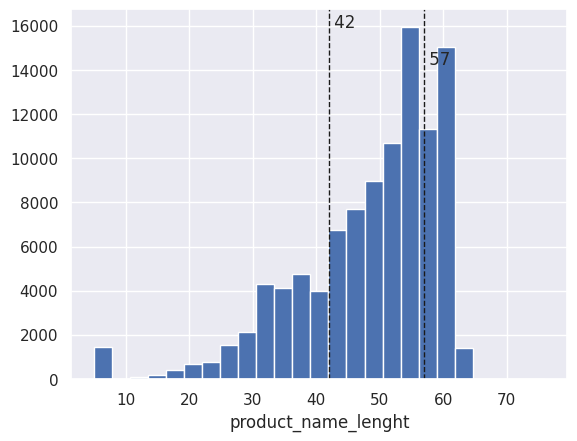

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_description_lenght
moyenne :  775.0866771006554
médiane :  595.0
mode :  0    4.0
Name: product_description_lenght, dtype: float64
min :  4.0
max :  3992.0
quartiles :  [341.0, 979.0]
variance :  425188.0324459964
écart-type :  652.0644388754814
coefficient de variation :  0.8412793796361463
skewness :  1.9878761869442145
kurtosis :  4.8977904775592


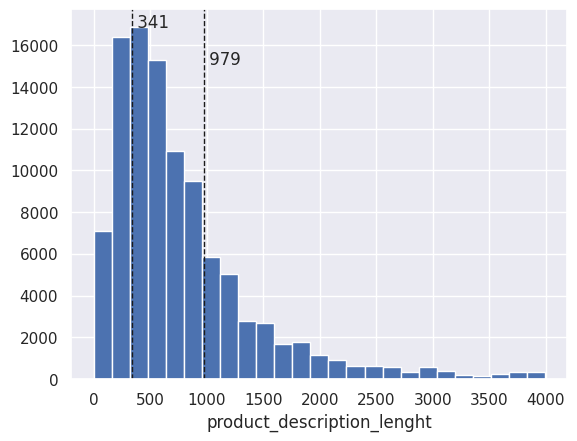

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_photos_qty
moyenne :  2.2198767485082658
médiane :  1.0
mode :  0    1.0
Name: product_photos_qty, dtype: float64
min :  1.0
max :  20.0
quartiles :  [1.0, 3.0]
variance :  3.014042946757617
écart-type :  1.736099924185707
coefficient de variation :  0.7820704124012057
skewness :  1.8986899412849012
kurtosis :  4.761527787074297


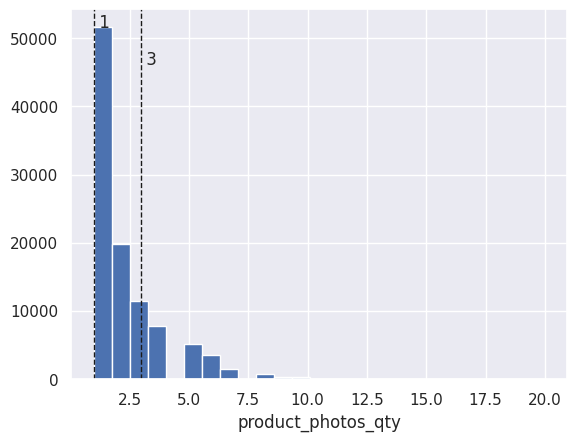

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_weight_g
moyenne :  2086.78770419642
médiane :  700.0
mode :  0    200.0
Name: product_weight_g, dtype: float64
min :  2.0
max :  40425.0
quartiles :  [300.0, 1800.0]
variance :  14035873.46310813
écart-type :  3746.448112960879
coefficient de variation :  1.7953182805452466
skewness :  3.629776613028226
kurtosis :  16.59266564932289


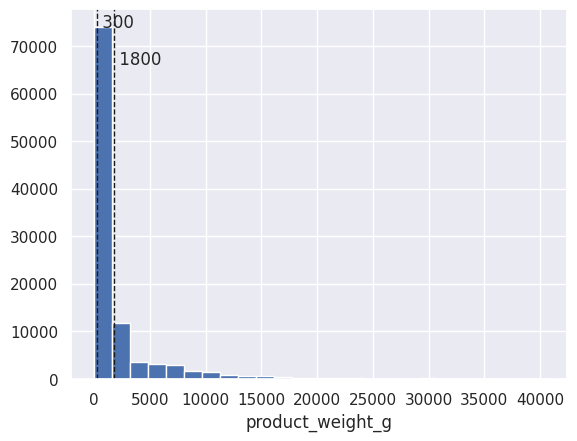

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_length_cm
moyenne :  30.080915582510027
médiane :  25.0
mode :  0    16.0
Name: product_length_cm, dtype: float64
min :  7.0
max :  105.0
quartiles :  [18.0, 38.0]
variance :  258.74123707621516
écart-type :  16.08543555755377
coefficient de variation :  0.5347388949459483
skewness :  1.7668888367353022
kurtosis :  3.7852536462476873


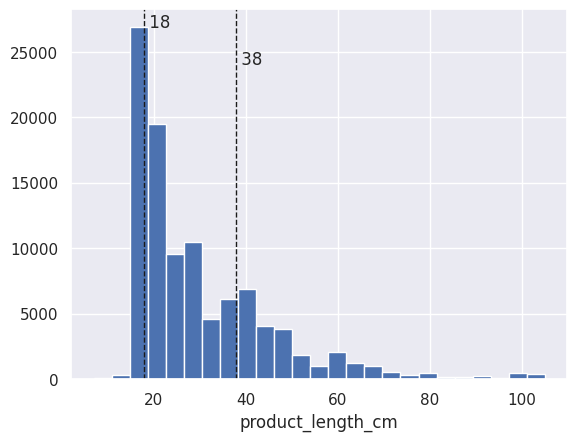

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_height_cm
moyenne :  16.390668101340115
médiane :  13.0
mode :  0    10.0
Name: product_height_cm, dtype: float64
min :  2.0
max :  105.0
quartiles :  [8.0, 20.0]
variance :  176.88404086245407
écart-type :  13.299775970385895
coefficient de variation :  0.8114236642555464
skewness :  2.276793647427155
kurtosis :  7.60708949699514


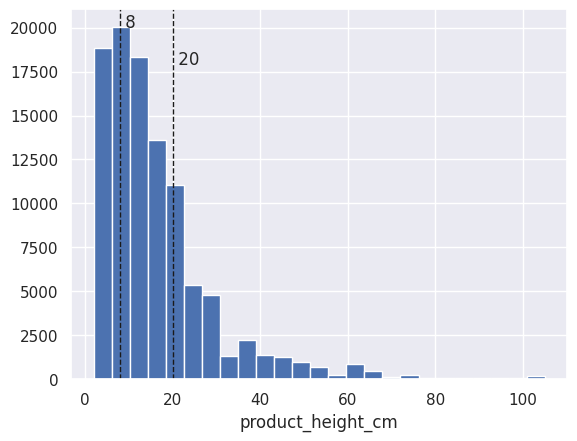

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_width_cm
moyenne :  23.04190550718967
médiane :  20.0
mode :  0    20.0
Name: product_width_cm, dtype: float64
min :  6.0
max :  118.0
quartiles :  [15.0, 30.0]
variance :  137.93800720734814
écart-type :  11.744701239595162
coefficient de variation :  0.509710502715607
skewness :  1.7066550991156189
kurtosis :  4.526775046915227


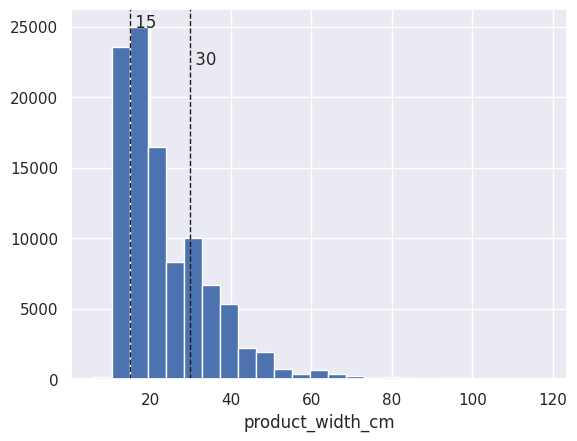

----------------------------------------------------------------------


In [89]:
plot_univarie(data_study, data_num.columns)

Il n'y a rien de particuliers à remarquer non plus en observant les répartition via les histogrammes. En revanche, nous pouvons afficher les pieplot des notes de review et de la quantité de photos, étant donné que les valeurs sont discrètes.

,%,%_cumul
categ,,
5,57.53,57.53
4,19.18,76.71
1,11.65,88.36
3,8.34,96.70
2,3.30,100.00


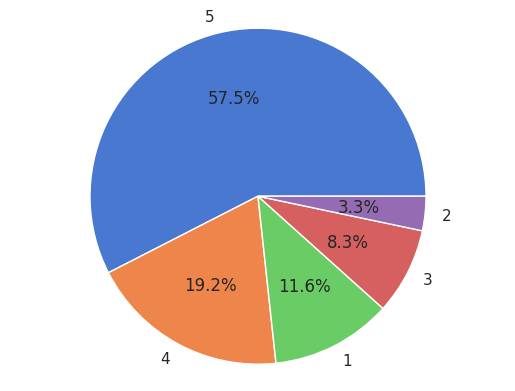

In [129]:
limit_perc = 3
show_unique_values(data_study, 'review_score')

In [91]:
maj_score_rev = data_study.loc[(data_study["review_score"]==5) | (data_study["review_score"]==4),:]
print("On peut voir que les notes 4 et 5 représentent", round(len(maj_score_rev)/len(data_study)*100, 1), "% des reviews.")

On peut voir que les notes 4 et 5 représentent 76.7 % des reviews.


,%,%_cumul
categ,,
1.0,50.54,50.54
2.0,19.38,69.92
3.0,11.22,81.14
4.0,7.59,88.73
5.0,4.98,93.71


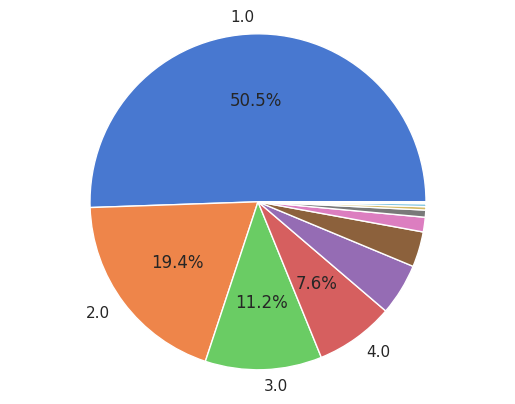

In [130]:
limit_perc = 5
show_unique_values(data_study, 'product_photos_qty')

In [167]:
maj_qty_photo = data_study.loc[(data_study["product_photos_qty"]==1) | (data_study["product_photos_qty"]==2) | (data_study["product_photos_qty"]==3),:]
print("On peut voir que les produits ayant 1 à 3 photos représentent", round(len(maj_qty_photo)/len(data_study)*100, 1), "% des fiches produit.")

On peut voir que les produits ayant 1 à 3 photos représentent 81.2 % des fiches produit.


### Colonnes Date

Colonne order_purchase_timestamp


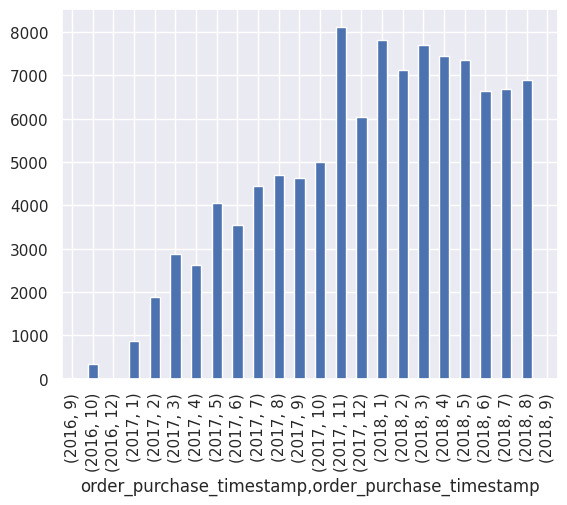

Colonne order_approved_at


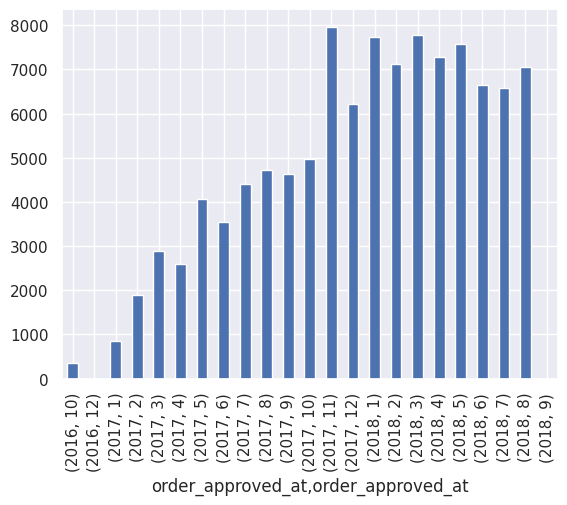

Colonne order_delivered_carrier_date


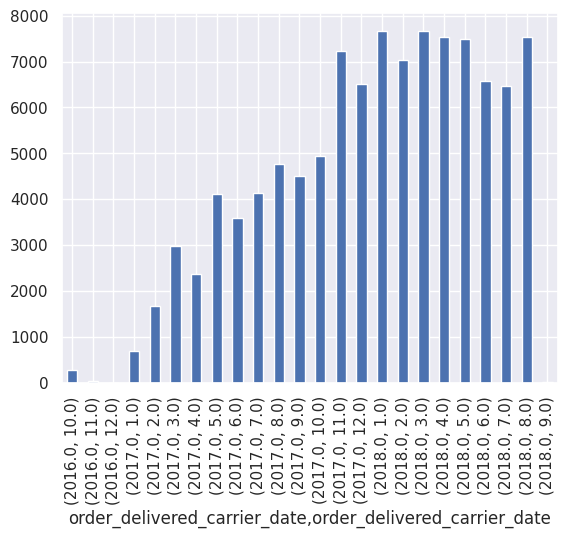

Colonne order_delivered_customer_date


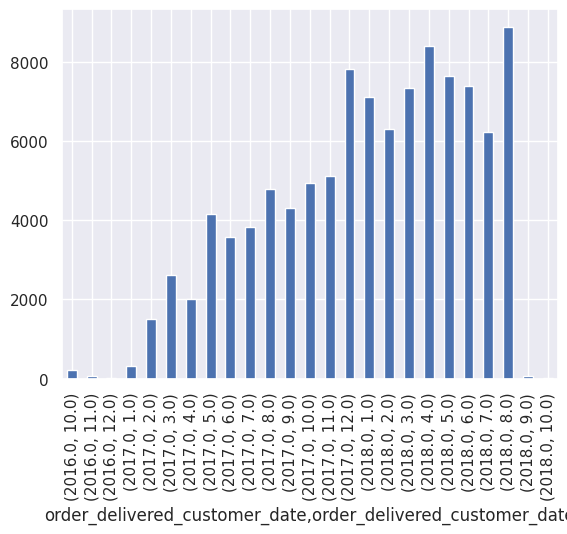

Colonne order_estimated_delivery_date


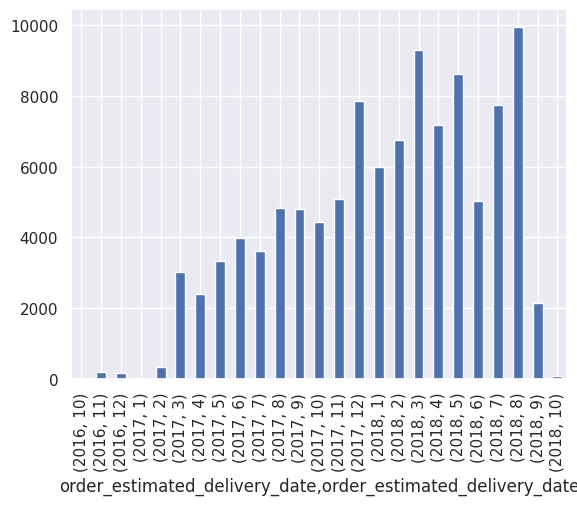

Colonne review_creation_date


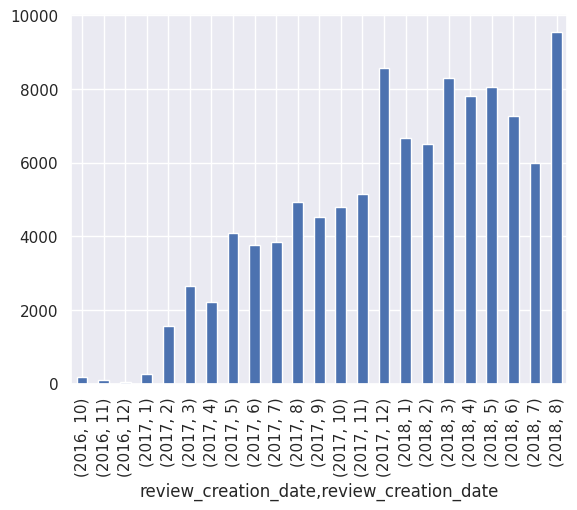

Colonne review_answer_timestamp


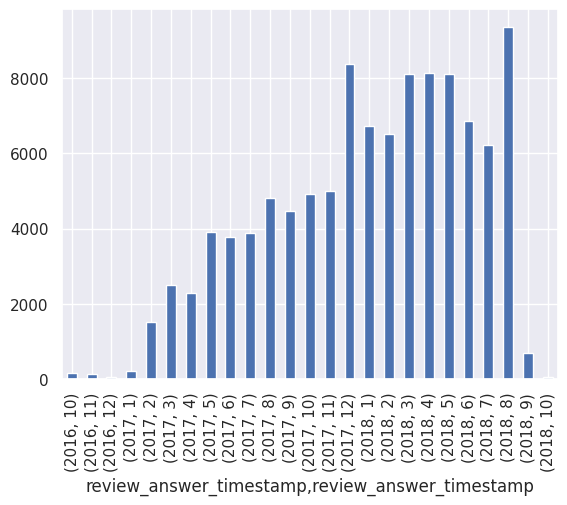

Colonne shipping_limit_date


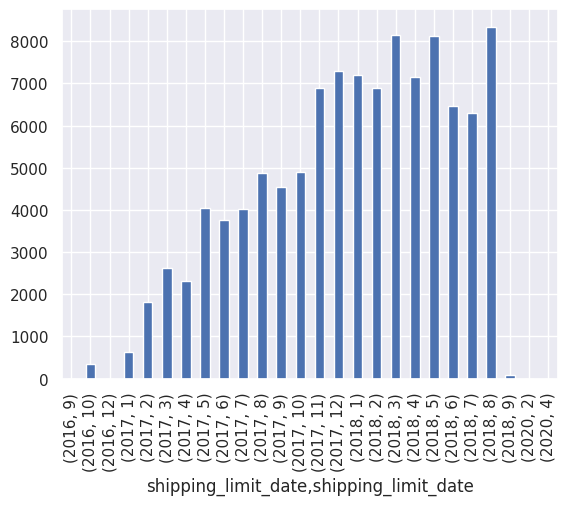

In [94]:
for col in data_date.columns:
    print("Colonne", col)
    data[col].groupby([data[col].dt.year, data[col].dt.month]).count().plot(kind="bar")
    plt.show()

La colonne `order_purchase_timestamp` sera utilisée dans le calcul des variables RFM. Nous avons des dates allant de 09/2016 à 04/2020. Il est surtout intéressant de voir que nous avons les données d'une entreprise en pleine expansion puisque le nombre d'éléments (clients, commandes, etc.) augmentent avec le temps.

In [100]:
# récupérer la période à laquelle appartient la date de la commande au format YYYY-mm
data_study["period"] = data_study['order_purchase_timestamp'].dt.strftime('%Y-%m')
data_study = data_study.sort_values(by="period")

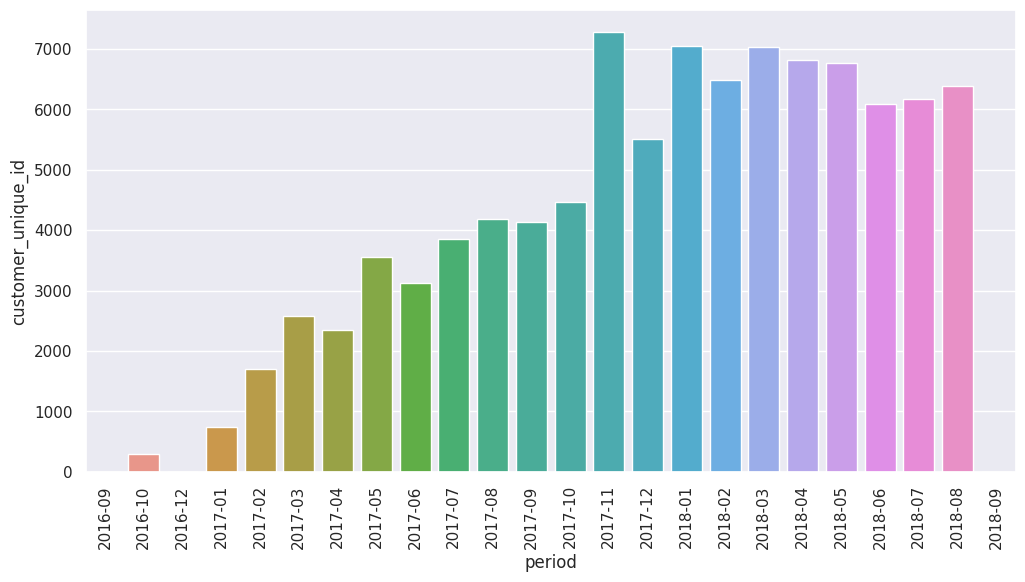

In [96]:
# on observe la répartition des commandes par période
df_monthly_active = data_study.groupby('period')['customer_unique_id'].nunique().reset_index()
fig, ax = plt.subplots(figsize=(12, 6))
sns.set(palette='muted', color_codes=True, style='whitegrid')
sns.barplot(x='period', y='customer_unique_id', data=df_monthly_active)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

## Analyse multivariée

### Colonnes Numériques et Catégorielles

In [105]:
show_corr_anova_col(data_study, categ_col_to_study, data_num.columns, threshold=0.2)

On dénombre 33 combinaisons à calculer.
----------------------------------------------------------------------
Colonne catégorielle : product_category_name
Colonne numérique : product_name_lenght
Correlation de 0.263
----------------------------------------------------------------------
Colonne catégorielle : product_category_name
Colonne numérique : product_length_cm
Correlation de 0.235
----------------------------------------------------------------------
Colonne catégorielle : product_category_name
Colonne numérique : product_height_cm
Correlation de 0.253
----------------------------------------------------------------------
Colonne catégorielle : product_category_name
Colonne numérique : product_width_cm
Correlation de 0.261
Corrélations ANOVA calculées en : 4.0 s, soit 0.0 min, soit 0.0 h.


La recherche de corrélation entre les variables catégorielles et les variables nuémriques n'a rien donné de pertinent. En effet, avec un seuil supérieure à 0.2, nous avons une corrélation entre la catégorie du produit et ses dimensions. Ce qui dans un sens peut être logique, par exemple, des bijoux sont souvent de petites tailles. Mais ce n'est pas vrai pour tout, c'est pour ça que la corrélation est faible.

### Colonnes Dates et Numériques

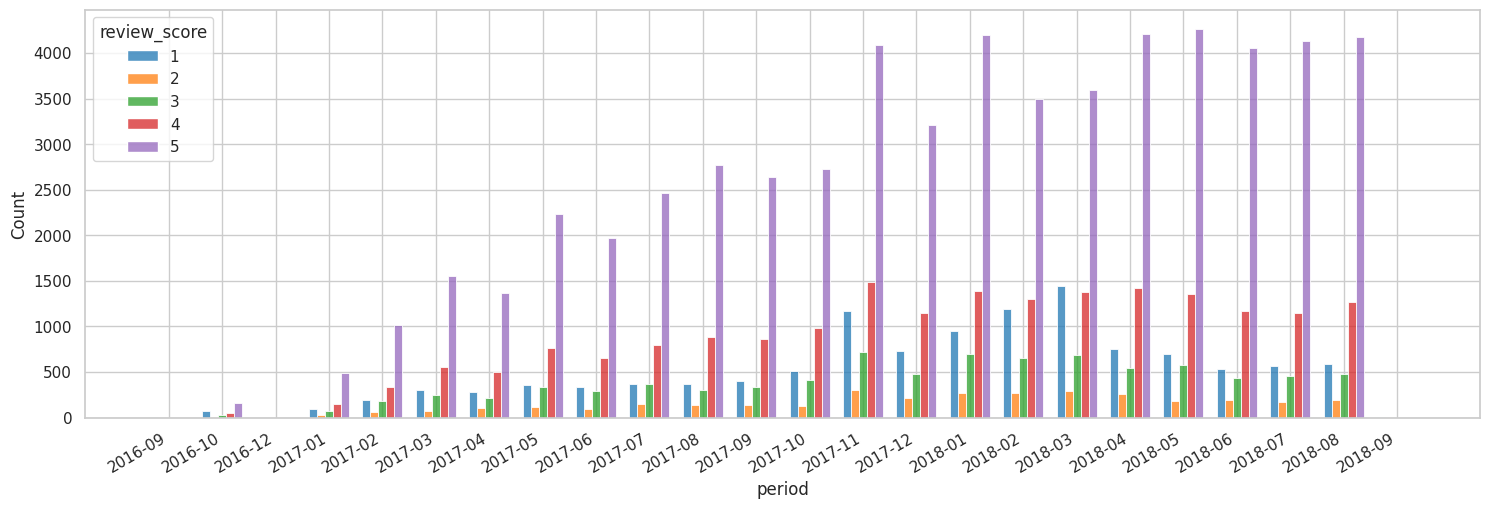

In [107]:
import matplotlib.dates as mdates
plt.figure(figsize=(18,6))
sns.histplot(data_study, x='period', hue='review_score',
             multiple='dodge', shrink=.75, bins=20, palette='tab10')
plt.gcf().autofmt_xdate()

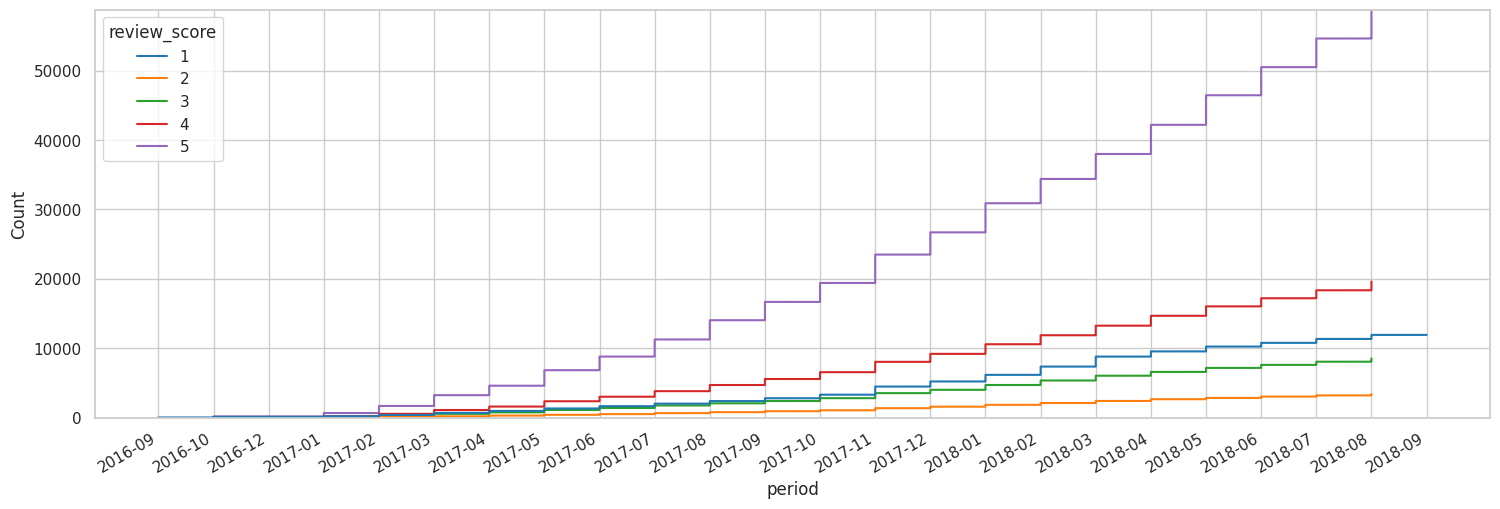

In [165]:
plt.figure(figsize=(18,6))
sns.ecdfplot(data_study, x='period', hue='review_score', palette='tab10', stat='count')
plt.gcf().autofmt_xdate()

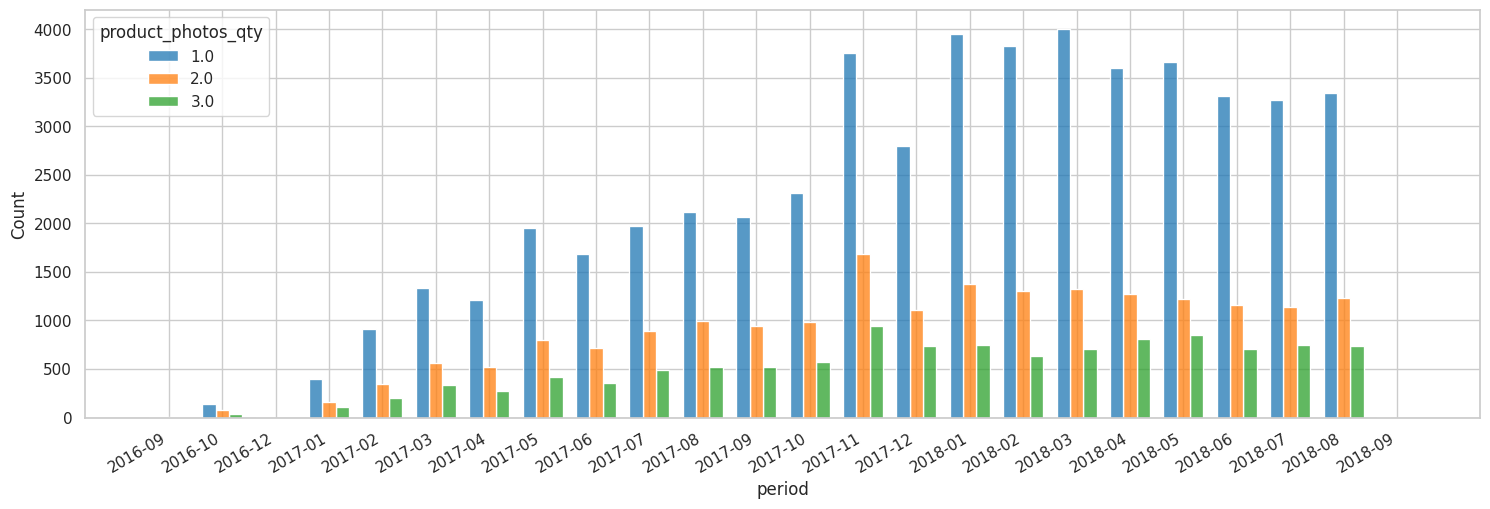

In [141]:
# on prend 80% des données pertinentes, càd un nb de photo de 1 à 3
maj_qty_photo = data_study.loc[data_study["product_photos_qty"].isin([1, 2, 3]),:]
plt.figure(figsize=(18,6))
sns.histplot(maj_qty_photo, x='period', hue='product_photos_qty',
             multiple='dodge', shrink=.75, bins=20, palette='tab10')
plt.gcf().autofmt_xdate()

### Colonnes Dates et Catégorielles

Concernant les états dans lesquels vivent les clients, nous allons étudier ceux qui représentent 50% des commandes : 
 - SP : São Paulo
 - RJ : Rio de Janeiro
 - MG : Minas Gerais
 - RS : Rio Grande de Sul
 - PR : Paraná
 - SC : Santa Catarina

A noter qu'il sont dans le top 10 des états les plus peuplés. Et si on met de côté la capitale Brasília, ce sont els états ayant le plus haut Index de Développement Humain (HDI) (entre 0.78 et 0.85). Il s'agit également des états situées dans les régions sud et sud-est du pays.

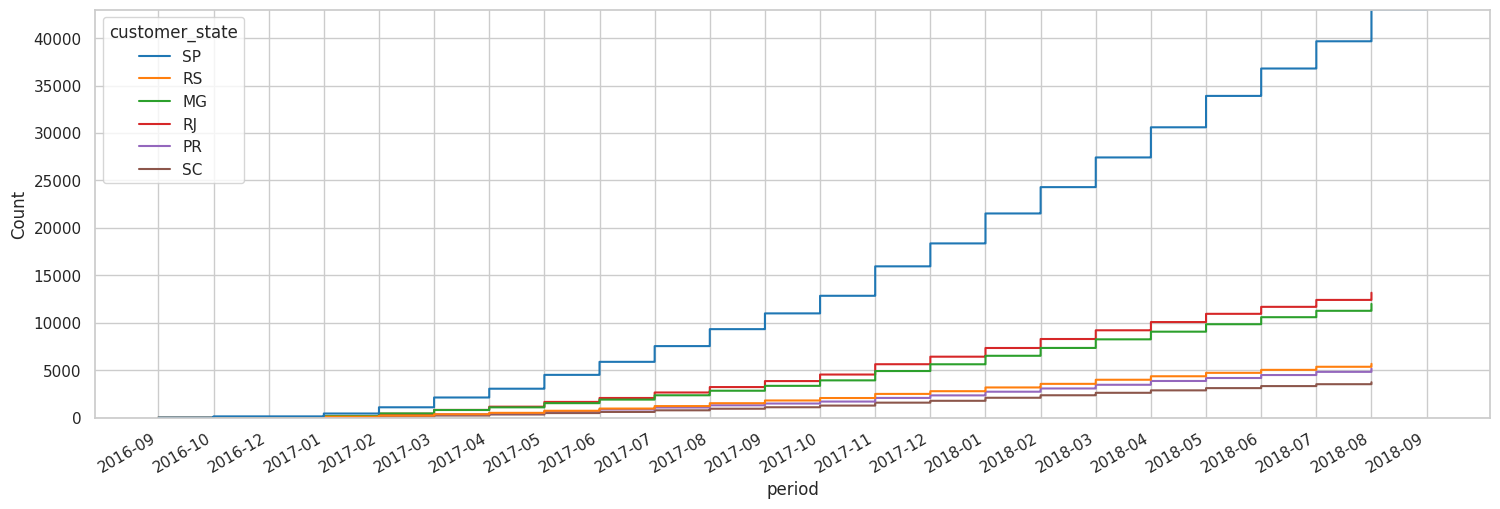

In [ ]:
# on prend 80% des données pertinentes
list_states_80 = ["SP", "RJ", "MG", "RS", "PR", "SC"]
maj_states = data_study.loc[data_study["customer_state"].isin(list_states_80), :]
plt.figure(figsize=(18,6))
sns.ecdfplot(maj_states, x='period', hue='customer_state', palette='tab10', stat='count')
plt.gcf().autofmt_xdate()

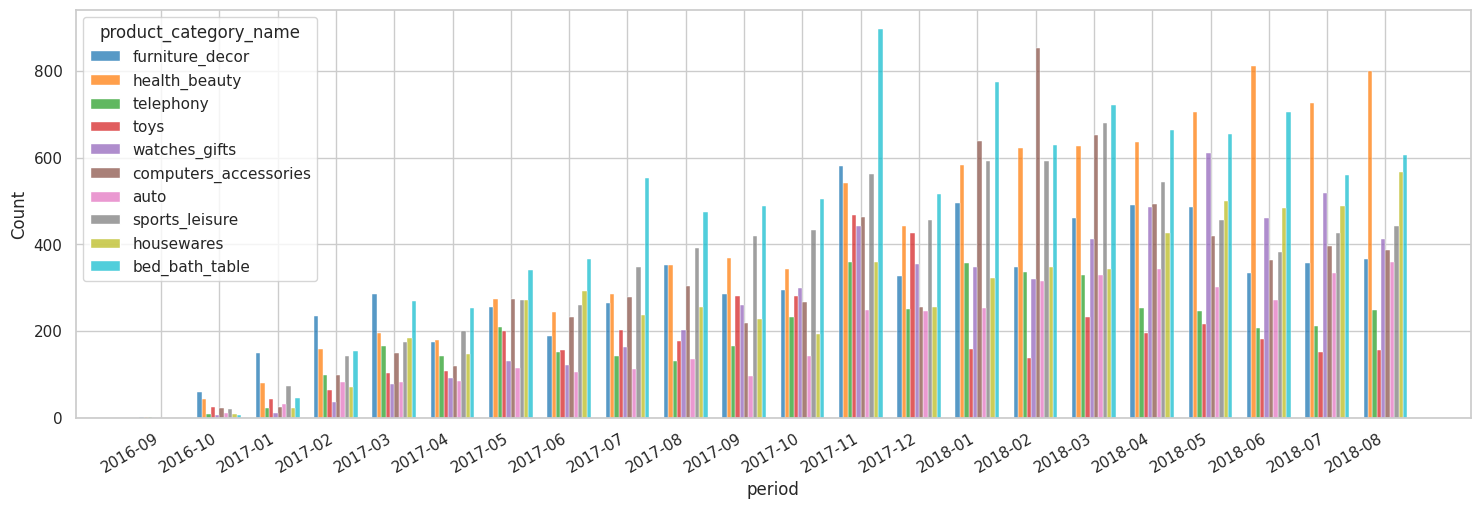

In [175]:
# on prend les 10 catégories les plus vendues, càd 60% des catégories
list_categories_10 = [
    "bed_bath_table", "health_beauty", "sports_leisure", "computers_accessories",
    "furniture_decor", "housewares", "watches_gifts", "telephony", "auto", "toys"]
    # "cool_stuff", "garden_tools", "perfumery", "baby", "electronics", "stationery"]
maj_categories = data_study.loc[data_study["product_category_name"].isin(list_categories_10), :]
plt.figure(figsize=(18,6))
sns.histplot(maj_categories, x='period', hue='product_category_name',
             multiple='dodge', shrink=.75, bins=20, palette='tab10')
plt.gcf().autofmt_xdate()

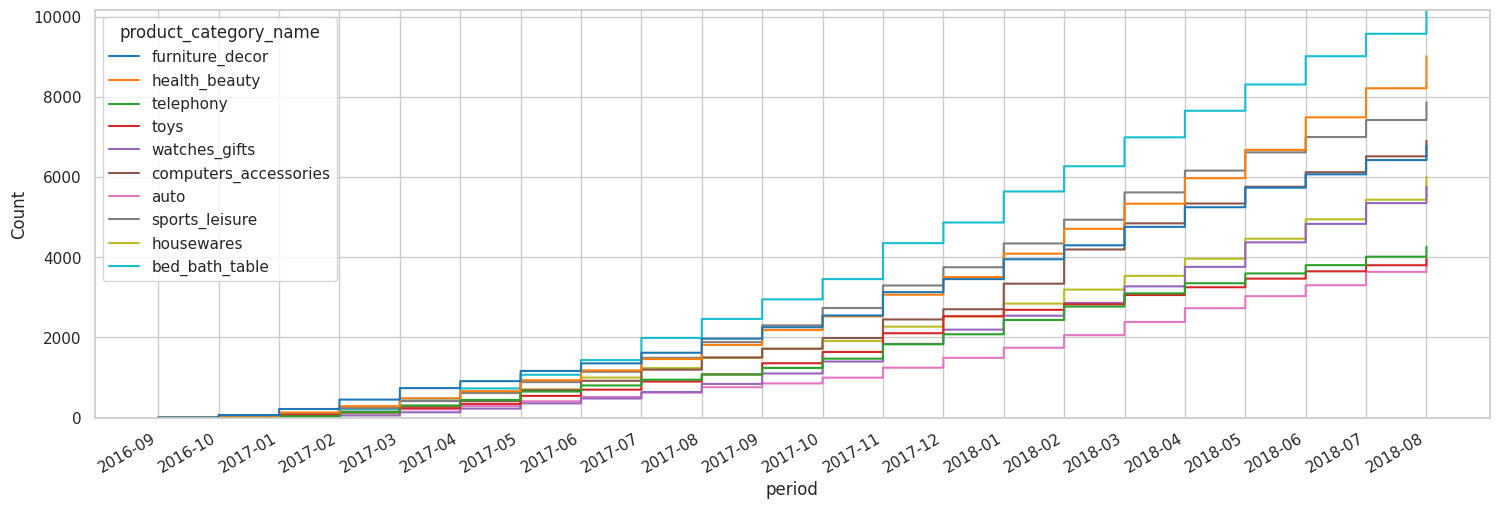

In [176]:
# on prend les 10 catégories les plus vendues, càd 60% des catégories
maj_categories = data_study.loc[data_study["product_category_name"].isin(list_categories_10), :]
plt.figure(figsize=(18,6))
sns.ecdfplot(maj_categories, x='period', hue='product_category_name', palette='tab10', stat='count')
plt.gcf().autofmt_xdate()

<Figure size 1800x600 with 0 Axes>

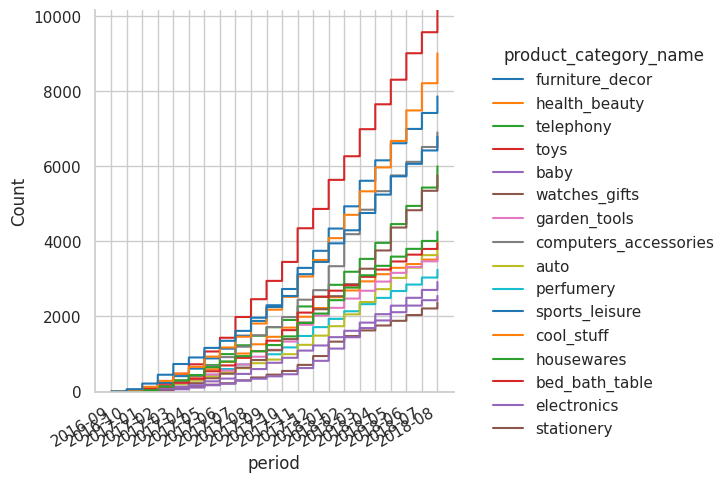

In [171]:
# on prend 80% des données pertinentes
list_categories_80 = [
    "bed_bath_table", "health_beauty", "sports_leisure", "computers_accessories",
    "furniture_decor", "housewares", "watches_gifts", "telephony", "auto", "toys",
    "cool_stuff", "garden_tools", "perfumery", "baby", "electronics", "stationery"
]
maj_categories = data_study.loc[data_study["product_category_name"].isin(list_categories_80), :]
plt.figure(figsize=(18,6))
sns.displot(maj_categories, x='period', hue='product_category_name', palette='tab10', stat='count', kind='ecdf')
plt.gcf().autofmt_xdate()

### truc muche